In [18]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# adjust this to point to your downloaded/trained model
model_path = os.path.join('.', 'snapshots', 'resnet50_coco_best_v2.0.2.h5')

# load retinanet model
model = keras.models.load_model(model_path, custom_objects=custom_objects)
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane',
                   5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light',
                   10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter',
                   13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse',
                   18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra',
                   23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag',
                   27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis',
                   31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat',
                   35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 
                   38: 'tennis racket', 39: 'bottle', 40: 'wine glass',
                   41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 
                   45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich',
                   49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 
                   54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',
                   59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop',
                   64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave',
                   69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock',
                   75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

/usr/local/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


processing time:  0.3377988338470459


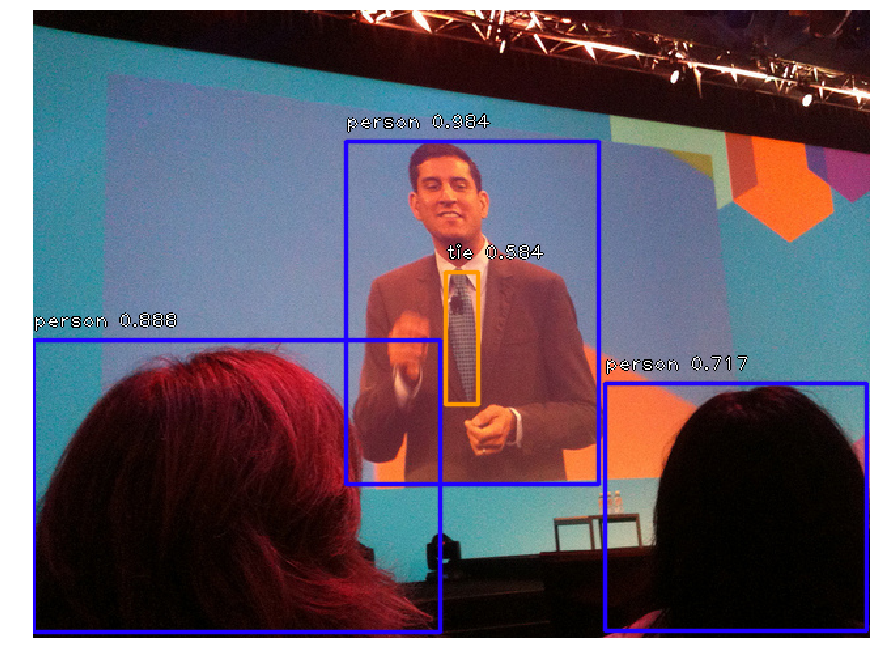

In [25]:
# load image
image = read_image_bgr('000000008021.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
_, _, boxes, nms_classification = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(nms_classification[0, :, :], axis=1)
scores = nms_classification[0, np.arange(nms_classification.shape[1]), predicted_labels]

# correct for image scale
boxes /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
        
    color = label_color(label)

    b = boxes[0, idx, :].astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [26]:
import colorsys
import random
N = len(labels_to_names)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = list(map(lambda x: tuple(255*np.array(colorsys.hsv_to_rgb(*x))), HSV_tuples))
random.shuffle(RGB_tuples)

In [27]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

GPU = get_available_gpus()[-1][17:33]
print(GPU)

Tesla K80, pci b


In [ ]:
cap = cv2.VideoCapture('./sf-hd-sample.mp4')

counter = 0
sum_time=0
while(True):
    ret, draw = cap.read()
    if not ret:
        break
    bgr = cv2.cvtColor(draw, cv2.COLOR_RGB2BGR)
    
    # preprocess image for network
    image = preprocess_image(bgr)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    _, _, boxes, nms_classification = model.predict_on_batch(np.expand_dims(image, axis=0))
    t = time.time() - start


    # compute predicted labels and scores
    #predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    #scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    
    # compute predicted labels and scores
    predicted_labels = np.argmax(nms_classification[0, :, :], axis=1)
    scores = nms_classification[0, np.arange(nms_classification.shape[1]), predicted_labels]


    # correct for image scale
    #nms_classification[0, :, :4] /= scale
    boxes /= scale
    
    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.5:
            continue
        
        color = label_color(label)

        b = boxes[0, idx, :].astype(int)
        draw_box(draw, b, color=color)
    
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)
        if sum_time>0:
            cv2.putText(draw, "%s Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(GPU, t,1.0/t,sum_time/counter,counter/sum_time), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 7)
            cv2.putText(draw, "%s Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(GPU, t,1.0/t,sum_time/counter,counter/sum_time), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    cv2.imwrite('/tmp/img%08d.jpg'%counter,draw)
    counter=counter+1
    sum_time+=t

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 